In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

from scipy.stats import pearsonr

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [14]:
def data_tracks_phase(data_tracks, var_name):
    """
    return area-related variables 
    """
    var_list = []
    track_list = []
    
    for track in data_tracks.tracks.values:

        track_list.append(track)
        tmp = data_tracks.sel(tracks=track)
        phase_list = [tmp.idt_mcs_init.values, tmp.idt_mcs_grow.values, tmp.idt_mcs_mature.values,
                      tmp.idt_mcs_decay.values, tmp.idt_mcs_end.values]

        ds = xr.Dataset(data_vars=dict(var_null=(['mcs_phase'], tmp[var_name].sel(times=phase_list).values)),
                        coords=dict(mcs_phase=(['mcs_phase'],['Init', 'Grow', 'Mature', 'Decay', 'End'])))

        var_list.append(ds)

    ds_xr = xr.concat(var_list, pd.Index(track_list, name='tracks')).rename_vars({'var_null':var_name})
        
    return ds_xr

In [83]:
def data_tracks_BL_features(files):
    """
    return tracks by BL_TOT bins (unit: K)
    """
    
    track_list = []
    BL_features_list = []    
        
    for file in files:
        
        track_list.append(int(file.name[-11:-6])) # save track number 
        
        tmp = xr.open_dataset(file)
        # calculate BL+ fraction and BL+ amplitude
        BL_mcs = tmp.Buoy_TOT.where(tmp.cloudtracknumber_nomergesplit > 0)
        BL_pos = BL_mcs.where(BL_mcs > 0, 0)
        BL_pos_nan = BL_mcs.where(BL_mcs > 0, np.nan)
        BL_pos_binary = BL_pos.where(BL_pos ==0, 1)
        mcs_area = tmp.cloudtracknumber_nomergesplit.sum(('x','y'))
        BL_pos_area = BL_pos_binary.sum(('x','y')).rename('BL_positive_area')
        BL_pos_frac = (BL_pos_area/mcs_area).rename('BL_positive_fraction')
        BL_tot_bp = BL_pos_nan.mean(('x','y')).rename('BL_TOT_bp')
        
        # BL estimates
        BL_tot_mcs = BL_mcs.mean(('x','y')).rename('BL_TOT_mcs')
        BL_cape_mcs = tmp.Buoy_CAPE.where(tmp.cloudtracknumber_nomergesplit > 0).mean(('x','y')).rename('BL_CAPE_mcs')
        BL_subsat_mcs = tmp.Buoy_SUBSAT.where(tmp.cloudtracknumber_nomergesplit > 0).mean(('x','y')).rename('BL_SUBSAT_mcs')
        
        # outside MCS
        BL_tot_ouside = tmp.Buoy_TOT.where(tmp.cloudtracknumber_nomergesplit == 0).mean(('x','y')).rename('BL_TOT_outside')
        BL_cape_ouside = tmp.Buoy_CAPE.where(tmp.cloudtracknumber_nomergesplit == 0).mean(('x','y')).rename('BL_CAPE_outside')
        BL_subsat_ouside = tmp.Buoy_SUBSAT.where(tmp.cloudtracknumber_nomergesplit == 0).mean(('x','y')).rename('BL_SUBSAT_outside')        
        
        # replace 0 by nan
        BL_pos_area = BL_pos_area.where(BL_pos_area > 0, np.nan)
        BL_pos_frac = BL_pos_frac.where(BL_pos_frac > 0, np.nan)
        
        BL_features_list.append(xr.merge([BL_pos_area, BL_pos_frac, BL_tot_bp, BL_tot_mcs,
                                         BL_cape_mcs, BL_subsat_mcs, BL_tot_ouside,
                                         BL_cape_ouside, BL_subsat_ouside]))
    
    BL_features_xr = xr.concat(BL_features_list, pd.Index(track_list, name='tracks'))
    
    return BL_features_xr

In [48]:
def data_tracks_precip_features(files):
    """
    return tracks by BL_TOT bins (unit: K)
    """
    
    track_list = []
    precip_features_list = []    
    corr_coeff_temp = []
        
    for file in files:
        
        track_list.append(int(file.name[-11:-6])) # save track number 
        
        tmp = xr.open_dataset(file)
        # calculate precip amplitude within mcs
        prec_mcs = tmp.precipitationCal.where(tmp.cloudtracknumber_nomergesplit > 0)
        mtpr_mcs = tmp.mtpr.where(tmp.cloudtracknumber_nomergesplit > 0)
        prec_amp_mcs = prec_mcs.mean(('x','y')).rename('precipitationCal_mcs')
        mtpr_amp_mcs = mtpr_mcs.mean(('x','y')).rename('mtpr_mcs')
        
        prec_mcs = tmp.precipitationCal.where(tmp.cloudtracknumber_nomergesplit > 0, 0)
        mtpr_mcs = tmp.mtpr.where(tmp.cloudtracknumber_nomergesplit > 0, 0)
        # estimate spatial correlation 
        corr_coeff = []
        for phase in tmp.mcs_phase:
            prec_era5 = prec_mcs.sel(mcs_phase=phase)
            prec_gpm = mtpr_mcs.sel(mcs_phase=phase)
            stats = pearsonr(prec_era5.values.ravel(), prec_gpm.values.ravel())
            corr_coeff.append(stats[0]) # save correlation coefficient 
        corr_coeff_space = xr.Dataset(data_vars=dict(corr_coeff_space=(['mcs_phase'],np.asarray(corr_coeff))),
                                 coords=dict(mcs_phase=(['mcs_phase'], tmp.mcs_phase.values)))
        
        # estimate temporal correlation 
        corr_coeff_temp.append(pearsonr(prec_amp_mcs.values.ravel(), mtpr_amp_mcs.values.ravel())[0])
        
        precip_features_list.append(xr.merge([prec_amp_mcs ,mtpr_amp_mcs,
                                              corr_coeff_space]))
    
    corr_coeff_temp_xr = xr.Dataset(data_vars=dict(corr_coeff_temp=(['tracks'],np.asarray(corr_coeff_temp))),
                                 coords=dict(tracks=(['tracks'], track_list)))
    precip_features_xr = xr.concat(precip_features_list, pd.Index(track_list, name='tracks'))

    # merge two datasets
    precip_features_xr = xr.merge([precip_features_xr, corr_coeff_temp_xr])
    
    return precip_features_xr

In [49]:
%%time

data_tracks_list = []

year_list = [2014,2015]
for year in year_list:

    print('processing year: {}'.format(year))
    # directory of the mcs_3dvars files
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
    files = sorted(list(dir_envs_track.glob('*.LD.nc')))

    # load data_tracks 
    data_tracks = xr.open_dataset('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))

    # write out BL_features dataset based on mcs_envs output
    data_BL_features = data_tracks_BL_features(files)
    data_precip_features = data_tracks_precip_features(files)
    
    # area-related variables
    data_ccs_area = data_tracks_phase(data_tracks, var_name='ccs_area')
    data_core_area = data_tracks_phase(data_tracks, var_name='core_area')
    data_cold_area = data_tracks_phase(data_tracks, var_name='cold_area')
    data_area_features = xr.merge([data_ccs_area, data_core_area, data_cold_area])
    
    corr_temp = data_precip_features.corr_coeff_temp
    corr_coeff_space = data_precip_features.corr_coeff_space.mean('mcs_phase')
    
    # filtering out tracks with low coherency in precip evolution
    cond_1 = corr_temp > 0.7
    cond_2 = corr_coeff_space > 0

    data_tracks_list.append(xr.merge([data_tracks['mcs_duration'].isel(tracks=np.where(cond_1 & cond_2)[0]),
                                data_BL_features.isel(tracks=np.where(cond_1 & cond_2)[0]),
                                data_precip_features.isel(tracks=np.where(cond_1 & cond_2)[0]),
                                data_area_features.isel(tracks=np.where(cond_1 & cond_2)[0])]
                                ))

processing year: 2014
processing year: 2015
CPU times: user 8min 40s, sys: 30.8 s, total: 9min 11s
Wall time: 17min 48s


In [50]:
# concatenate multi-year tracks into one dataset

data_tracks_sum = []
number_multiyr = 0 # relabeling starting from 1

for data_tracks_singleyr in data_tracks_list:
    
    number_multiyr += len(data_tracks_singleyr.tracks)
    for i in range(len(data_tracks_singleyr.tracks)):
        tmp = data_tracks_singleyr.isel(tracks=i).drop('tracks')
        data_tracks_sum.append(tmp)
        
data_tracks_multiyr = xr.concat(data_tracks_sum, pd.Index(np.arange(1,number_multiyr+1), name='samples'))

In [60]:
mcs_duration = data_tracks_multiyr.mcs_duration
idx_SL = np.where(np.logical_and(mcs_duration > 5, mcs_duration < 12))[0]
idx_LL = np.where(np.logical_and(mcs_duration > 24, mcs_duration < 48))[0]

In [61]:
data_tracks_SL = data_tracks_multiyr.isel(samples=idx_SL)
data_tracks_LL= data_tracks_multiyr.isel(samples=idx_LL)

In [62]:
data_tracks_multiyr

<xarray.Dataset>
Dimensions:               (samples: 1643, mcs_phase: 5)
Coordinates:
  * mcs_phase             (mcs_phase) object 'Init' 'Grow' ... 'Decay' 'End'
  * samples               (samples) int64 1 2 3 4 5 ... 1639 1640 1641 1642 1643
Data variables: (12/14)
    mcs_duration          (samples) int64 20 32 4 5 8 8 9 ... 19 13 38 9 7 4 28
    BL_positive_area      (samples, mcs_phase) float64 8.0 6.0 19.0 ... nan nan
    BL_positive_fraction  (samples, mcs_phase) float64 0.04255 0.03571 ... nan
    BL_TOT_bp             (samples, mcs_phase) float64 0.005377 0.002932 ... nan
    BL_TOT_mcs            (samples, mcs_phase) float64 -0.02535 ... -0.05387
    BL_CAPE_mcs           (samples, mcs_phase) float64 0.006806 ... -0.001791
    ...                    ...
    mtpr_mcs              (samples, mcs_phase) float64 0.3748 1.721 ... 0.6593
    corr_coeff_space      (samples, mcs_phase) float64 0.04833 0.2312 ... 0.125
    corr_coeff_temp       (samples) float64 0.7223 0.8738 ... 0.7781 0.7289
    ccs_area              (samples, mcs_phase) float32 9.42e+04 ... 4.51e+04
    core_area             (samples, mcs_phase) float32 4.92e+04 ... 6.1e+03
    cold_area             (samples, mcs_phase) float32 4.5e+04 ... 3.9e+04
Attributes:
    long_name:  Duration of MCS stage
    units:      unitless
    comments:   Multiply by time_resolution_hour to convert to physical units

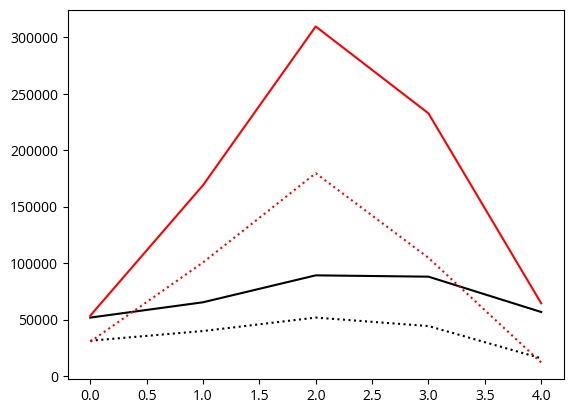

In [63]:

plt.plot(data_tracks_SL.ccs_area.mean('samples'), color='k')
plt.plot(data_tracks_LL.ccs_area.mean('samples'), color='r')
plt.plot(data_tracks_SL.core_area.mean('samples'), color='k', linestyle=':')
plt.plot(data_tracks_LL.core_area.mean('samples'), color='r', linestyle=':')

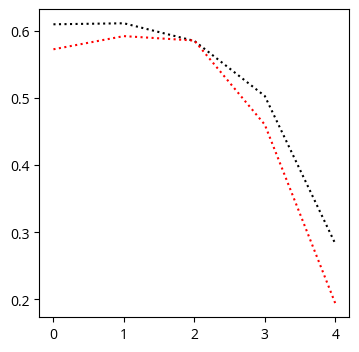

In [66]:
fig = plt.figure(figsize=(4,4))

plt.plot((data_tracks_SL.core_area/data_tracks_SL.ccs_area).mean('samples'), color='k', linestyle=':')
plt.plot((data_tracks_LL.core_area/data_tracks_LL.ccs_area).mean('samples'), color='r', linestyle=':')

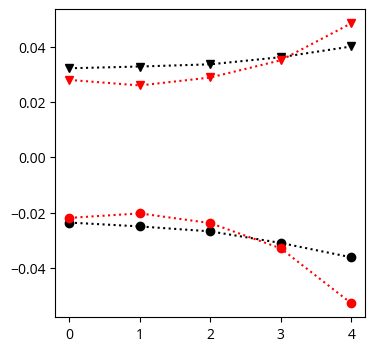

In [77]:
fig = plt.figure(figsize=(4,4))

plt.plot((data_tracks_SL.BL_TOT_mcs).mean('samples'), marker='o', color='k', linestyle=':')
plt.plot((data_tracks_LL.BL_TOT_mcs).mean('samples'), marker='o', color='r', linestyle=':')

#plt.plot((data_tracks_SL.BL_CAPE_mcs).mean('samples'), marker='^', color='k', linestyle=':')
#plt.plot((data_tracks_LL.BL_CAPE_mcs).mean('samples'), marker='^', color='r', linestyle=':')

plt.plot((data_tracks_SL.BL_SUBSAT_mcs).mean('samples'), marker='v', color='k', linestyle=':')
plt.plot(-(data_tracks_LL.BL_SUBSAT_mcs).mean('samples'), marker='v', color='r', linestyle=':')
#plt.plot((data_tracks_LL.BL_TOT_mcs).mean('samples'), color='r', linestyle=':')

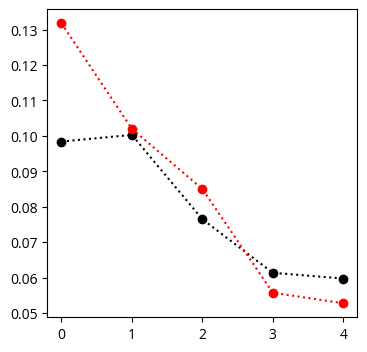

In [79]:
fig = plt.figure(figsize=(4,4))

plt.plot((data_tracks_SL.BL_positive_fraction).mean('samples'), marker='o', color='k', linestyle=':')
plt.plot((data_tracks_LL.BL_positive_fraction).mean('samples'), marker='o', color='r', linestyle=':')

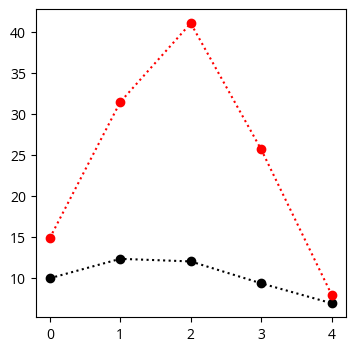

In [81]:
fig = plt.figure(figsize=(4,4))

plt.plot((data_tracks_SL.BL_positive_area).mean('samples'), marker='o', color='k', linestyle=':')
plt.plot((data_tracks_LL.BL_positive_area).mean('samples'), marker='o', color='r', linestyle=':')